In [1]:
import pandas as pd
import numpy as np
import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from collections import defaultdict
from nltk.corpus import wordnet as wn

import warnings
import keras
from keras import models
from keras.models import Sequential
from keras import layers
from keras.layers import Embedding, Bidirectional, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Reshape, TimeDistributed, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping
import tensorflow as tf
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn import metrics

Using TensorFlow backend.


## Read the Datasets

In [2]:
df=pd.read_json(r"./../../Dataset/Sarcasm_Headlines_Dataset_v2/Sarcasm_Headlines_Dataset_v2.json",lines=True)

In [3]:
df.shape

(28619, 3)

In [4]:
df.columns

Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')

In [5]:
df['is_sarcastic'].value_counts()

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [6]:
#Check for any null values int he dataset
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [7]:
# Check for any duplicate rows

In [8]:
df['article_link'].nunique()

28617

In [9]:
#There are 2 duplicate rows
df.duplicated().sum()

2

In [10]:
#Remove duplicate rows
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(inplace=True)

In [11]:
#No duplicated found
df.duplicated().sum()

0

## Data Cleaning

## Step 1:
### Remove Special Characters
### Check if numbers are required
### Remove anomalies like 1a 2b

In [12]:
%%time
df1=df.copy()

#Remove all single letter words
df1['headline']=df1['headline'].apply(lambda x: re.sub(r"[^\w\s]"," ",str(x)))

#Remove all numbers
df1['headline']=df1['headline'].apply(lambda x: re.sub(r'\d',"",str(x)))

#Remove extra spaces
df1['headline']=df1['headline'].apply(lambda x: " ".join(x.split()))

Wall time: 180 ms


## Step 2:
### Convert to lower case
### Remove Stopwords and special words that need to be removed
### Perform Lemmatization

In [13]:
%%time
stop=set(stopwords.words('english'))
#Update any words that we want to remove here
custom_list=['nan']
stop.update(custom_list)

tadDict = defaultdict(lambda : wn.NOUN)
tadDict['J'] = wn.ADJ
tadDict['V'] = wn.VERB
tadDict['R'] = wn.ADV

#Convert to lower case
df1['headline']=df1['headline'].apply(lambda x: x.lower())

#Remove stopwords
# df1['headline']=df1['headline'].apply(lambda x: " ".join([i for i in word_tokenize(x) if i.casefold() not in map(str.casefold,stop)]))

#Perform Lemmatization
df1['headline']=df1['headline'].apply(lambda x: " ".join(WordNetLemmatizer().lemmatize(word,tadDict[tag[0]]) for word,tag in pos_tag(word_tokenize(x))))

#Remove all single letter words
df1['headline']=df1['headline'].apply(lambda x: re.sub(r"( [a-z]{1} )|(^[a-z]{1} )|( [a-z]{1}$)"," ",str(x)))

#Remove extra spaces
df1['headline']=df1['headline'].apply(lambda x: " ".join(x.split()))

Wall time: 50.5 s


In [14]:
df_cleaned=df1.copy()

In [15]:
df['headline'][7]

"richard branson's global-warming donation nearly as much as cost of failed balloon trips"

In [16]:
df_cleaned['headline'][7]

'richard branson global warm donation nearly as much cost of failed balloon trip'

In [17]:
# Removing records that are having Null after cleaning.
df_cleaned=df_cleaned[df_cleaned['headline'].apply(lambda x: len(x)) > 0]

In [18]:
from collections import Counter
corpus=" ".join(df_cleaned['headline'])
corpus_split=corpus.split()
Counter=Counter(corpus_split)
most_occur = Counter.most_common(4)
most_occur

[('to', 9107), ('of', 6295), ('the', 5535), ('in', 4599)]

### Create Word Embeddings using Word2Vec

In [19]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from sklearn import linear_model
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.linear_model import SGDClassifier
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.metrics import precision_score, accuracy_score, recall_score
# from sklearn.decomposition import TruncatedSVD

import gensim
from gensim import corpora
from gensim import models
from gensim import similarities

from gensim.models import Word2Vec
from multiprocessing import cpu_count

In [20]:
def read_corpus(df):
    for i in df['headline']:
        tokens=gensim.utils.simple_preprocess(i)
        yield tokens
    
train_corpus=list(read_corpus(df_cleaned))

In [21]:
size=200
model=gensim.models.word2vec.Word2Vec(size=size,min_count=1,hs=1,sg=1,window=8,workers=cpu_count())
model.init_sims(replace=True)

model.build_vocab(train_corpus)
model.train(train_corpus,total_examples=model.corpus_count,epochs=model.epochs)

(1240897, 1411750)

In [22]:
model.most_similar('close')

[('keg', 0.788276195526123),
 ('blank', 0.7799274325370789),
 ('zaire', 0.7761216163635254),
 ('excruciate', 0.7722539901733398),
 ('whenever', 0.7709060311317444),
 ('polling', 0.7692815661430359),
 ('uphill', 0.7685390710830688),
 ('confide', 0.7681942582130432),
 ('overthrow', 0.7657268047332764),
 ('nostalgically', 0.7649931907653809)]

### Creating Sentence Vectors

Word2Vec gives us embeddings for a particular word. But we need to embedding for whole sentence(s).

So, to convert the embedding for word to sentence we take the sum of all the words present in a sentence and divide it by the total number of unique words in that sentence. It is like taking average vector for the whole sentence using each vector of the word.

    For each row or sentence:
        - Append all the word vectors to form a matrix with size (# of words,vector size)
        - Take column wise sum of the matrix created
        - Divide the sum by number of the unique words in that row or sentence

In [23]:
def sentence_vector(sentence,model):
    sent_vec=[]
    for i in sentence:
        aa=[]
        tokens=gensim.utils.simple_preprocess(i)
        nunique_words=len(set(i.split()))
        for j in tokens:
            aa.append(model.wv[j])
        bb=pd.DataFrame(aa)
        cc=bb.sum(axis=0)/nunique_words
        sent_vec.append(cc)
    
    return pd.DataFrame(sent_vec)

In [24]:
%%time
headlines_vec=sentence_vector(df_cleaned['headline'],model)
min_max_scaler = preprocessing.MinMaxScaler()
headlines_vec = min_max_scaler.fit_transform(headlines_vec)
headlines_vec.shape

Wall time: 5min 45s


(28617, 200)

In [25]:
labels=df_cleaned['is_sarcastic']

## Creating Test Training Split

In [26]:
#training and test data splits
x_train, x_test, y_train, y_test = train_test_split(headlines_vec, labels, test_size = 0.1, random_state = 0)
x_train, x_val,  y_train, y_val  = train_test_split(x_train, y_train, test_size = 0.11, random_state = 0)

### Reshape the embeddings accordingly for input to LSTM

- Samples: One sequence is one sample. A batch is comprised of one or more samples.
- Time Steps: One time step is one point of observation in the sample.
- Features: One feature is one observation at a time step.

In [27]:
x_train=x_train.reshape(x_train.shape[0],1,x_train.shape[1])
x_val  =x_val.reshape(x_val.shape[0],1,x_val.shape[1])
x_test =x_test.reshape(x_test.shape[0],1,x_test.shape[1])

In [28]:
y_train=np.array(y_train).reshape(y_train.shape[0],1)
y_val  =np.array(y_val).reshape(y_val.shape[0],1)
y_test =np.array(y_test).reshape(y_test.shape[0],1)

In [29]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(22921, 1, 200)
(22921, 1)
(2834, 1, 200)
(2834, 1)
(2862, 1, 200)
(2862, 1)


# Classification Task

## LSTM 32 nodes without Dropouts

In [30]:
# create the model
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.50, patience=2, verbose=1, mode='auto', cooldown=0, min_lr=0.00001)

early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

model = Sequential()
model.add(LSTM(32,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(model.summary())

history  = model.fit(np.array(x_train), np.array(y_train),
 epochs= 30,
 batch_size = 100,
 validation_data = (np.array(x_val), np.array(y_val)),
 callbacks = [reduce_lr, early]
)

score = model.evaluate(x_test, y_test, verbose = 2)
print("score    : %.2f" % (score[0]*100))
print("Accuracy : %.2f%%" % (score[1]*100))
print("Precision: %.2f%%" % (score[2]*100))
print("Recall   : %.2f%%" % (score[3]*100))
print("F1-Score : %.2f%%" % ((2*(score[2]*score[3])/(score[2]+score[3]))*100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 29,857
Trainable params: 29,857
Non-trainable params: 0
_________________________________________________________________
None
Train on 22921 samples, validate on 2834 samples
Epoch 1/30
22921/22921 [==============================] - 3s 147us/step - loss: 0.6288 - accuracy: 0.6518 - precision: 0.5910 - recall: 0.3867 - val_loss: 0.5426 - val_accuracy: 0.7495 - val_precision: 0.6843 - val_recall: 0.5242
Epoch 2/30
22921/22921 [==============================] - 2s 88us/step - loss: 0.5102 - accuracy: 0.7588 - precision: 0.7074 - recall: 0.5868 - val_loss: 0.4922 - val_accuracy: 0.7671 - val_precision: 0.7233 - val_recall: 0.6327

<AxesSubplot:>

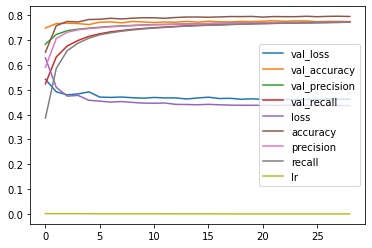

In [31]:
pd.DataFrame(history.history).plot(kind='line')

## LSTM 128 nodes without Dropouts

In [32]:
# create the model
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.50, patience=2, verbose=1, mode='auto', cooldown=0, min_lr=0.00001)

early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

model = Sequential()
model.add(LSTM(128,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(model.summary())

history  = model.fit(np.array(x_train), np.array(y_train),
 epochs= 30,
 batch_size = 100,
 validation_data = (np.array(x_val), np.array(y_val)),
 callbacks = [reduce_lr, early]
)

score = model.evaluate(x_test, y_test, verbose = 2)
print("score    : %.2f" % (score[0]*100))
print("Accuracy : %.2f%%" % (score[1]*100))
print("Precision: %.2f%%" % (score[2]*100))
print("Recall   : %.2f%%" % (score[3]*100))
print("F1-Score : %.2f%%" % ((2*(score[2]*score[3])/(score[2]+score[3]))*100))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 168,577
Trainable params: 168,577
Non-trainable params: 0
_________________________________________________________________
None
Train on 22921 samples, validate on 2834 samples
Epoch 1/30
22921/22921 [==============================] - 2s 107us/step - loss: 0.5869 - accuracy: 0.6981 - precision_1: 0.6540 - recall_1: 0.5106 - val_loss: 0.5246 - val_accuracy: 0.7315 - val_precision_1: 0.7139 - val_recall_1: 0.6191
Epoch 2/30
22921/22921 [==============================] - 2s 83us/step - loss: 0.4804 - accuracy: 0.7724 - precision_1: 0.7317 - recall_1: 0.6548 - val_loss: 0.5030 - val_accuracy: 0.7488 - val_precision_1: 0.7430 - va

<AxesSubplot:>

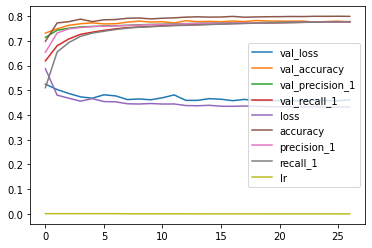

In [33]:
pd.DataFrame(history.history).plot(kind='line')

## LSTM 128 nodes with Dropouts

In [34]:
# create the model
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.50, patience=2, verbose=1, mode='auto', cooldown=0, min_lr=0.00001)

early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

model = Sequential()
model.add(LSTM(128,dropout=0.02,recurrent_dropout=0.02,input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(model.summary())

history  = model.fit(np.array(x_train), np.array(y_train),
 epochs= 30,
 batch_size = 100,
 validation_data = (np.array(x_val), np.array(y_val)),
 callbacks = [reduce_lr, early]
)

score = model.evaluate(x_test, y_test, verbose = 2)
print("score    : %.2f" % (score[0]*100))
print("Accuracy : %.2f%%" % (score[1]*100))
print("Precision: %.2f%%" % (score[2]*100))
print("Recall   : %.2f%%" % (score[3]*100))
print("F1-Score : %.2f%%" % ((2*(score[2]*score[3])/(score[2]+score[3]))*100))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 168,577
Trainable params: 168,577
Non-trainable params: 0
_________________________________________________________________
None
Train on 22921 samples, validate on 2834 samples
Epoch 1/30
22921/22921 [==============================] - 3s 116us/step - loss: 0.6246 - accuracy: 0.6468 - precision_2: 0.5692 - recall_2: 0.4573 - val_loss: 0.5194 - val_accuracy: 0.7484 - val_precision_2: 0.6565 - val_recall_2: 0.5710
Epoch 2/30
22921/22921 [==============================] - 2s 95us/step - loss: 0.5171 - accuracy: 0.7472 - precision_2: 0.6879 - recall_2: 0.6203 - val_loss: 0.5097 - val_accuracy: 0.7502 - val_precision_2: 0.7000 - va

<AxesSubplot:>

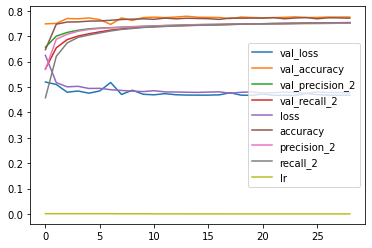

In [35]:
pd.DataFrame(history.history).plot(kind='line')

## Bi-Directional LSTM 128 nodes without Dropouts

In [36]:
# create the model
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.50, patience=2, verbose=1, mode='auto', cooldown=0, min_lr=0.00001)

early = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

model = Sequential()
model.add(Bidirectional(LSTM(128),input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
print(model.summary())

history  = model.fit(np.array(x_train), np.array(y_train),
 epochs= 30,
 batch_size = 100,
 validation_data = (np.array(x_val), np.array(y_val)),
 callbacks = [reduce_lr, early]
)

score = model.evaluate(x_test, y_test, verbose = 2)
print("score    : %.2f" % (score[0]*100))
print("Accuracy : %.2f%%" % (score[1]*100))
print("Precision: %.2f%%" % (score[2]*100))
print("Recall   : %.2f%%" % (score[3]*100))
print("F1-Score : %.2f%%" % ((2*(score[2]*score[3])/(score[2]+score[3]))*100))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 337,153
Trainable params: 337,153
Non-trainable params: 0
_________________________________________________________________
None
Train on 22921 samples, validate on 2834 samples
Epoch 1/30
22921/22921 [==============================] - 4s 159us/step - loss: 0.5870 - accuracy: 0.6935 - precision_3: 0.6217 - recall_3: 0.5625 - val_loss: 0.4990 - val_accuracy: 0.7548 - val_precision_3: 0.6977 - val_recall_3: 0.6442
Epoch 2/30
22921/22921 [==============================] - 3s 118us/step - loss: 0.4780 - accuracy: 0.7744 - precision_3: 0.7206 - recall_3: 0.6779 - val_loss: 0.5314 - val_accuracy: 0.7410 - val_precision_3: 0.7299 - v

<AxesSubplot:>

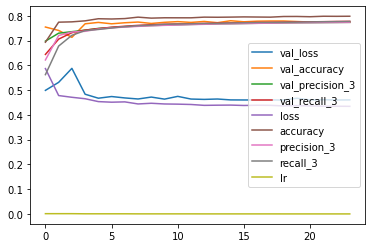

In [37]:
pd.DataFrame(history.history).plot(kind='line')